# Config

In [1]:
!nvidia-smi

Sun Jul 19 12:57:25 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.33.01    Driver Version: 440.33.01    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce RTX 208...  Off  | 00000000:01:00.0 Off |                  N/A |
| 30%   54C    P0    57W / 250W |      0MiB / 11018MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce RTX 208...  Off  | 00000000:0A:00.0 Off |                  N/A |
|  0%   72C    P0    56W / 260W |      0MiB / 11019MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
        

In [2]:
# !apt-get update
# !apt-get install git -y
#!apt-get install libgtk2.0-dev -y

In [3]:
# !pip install pytorchcv
# !pip install ipywidgets
# !jupyter nbextension enable --py widgetsnbextension
# !jupyter nbextension enable --py widgetsnbextension --sys-prefix

In [ ]:
#!pip install opencv-python
#!pip install scikit-image
#!pip install efficientnet-pytorch
#!pip install git+https://github.com/ildoonet/pytorch-gradual-warmup-lr.git
#!pip uninstall warmup_scheduler -y
'''
!pip install torch-summary
!pip install neptune-notebooks
!pip install torchvision
!pip install scikit-multilearn
!pip install iterative-stratification
!pip install pretrainedmodels
!pip install -U git+https://github.com/albu/albumentations
!pip install neptune-client
#!pip install git+https://github.com/pytorch/ignite
#!pip install torchtoolbox
#!pip install -U git+https://github.com/PistonY/torch-toolbox.git@master
'''

In [5]:
#!git clone https://github.com/NVIDIA/apex

In [6]:
#cd apex

In [7]:
#!pip install -v --no-cache-dir --global-option="--cpp_ext" --global-option="--cuda_ext" ./

In [8]:
#cd ..

In [9]:
class CFG:
    debug=False
    image_size=256
    lr=0.0008#1e-3
    batch_size=8
    epochs=30 
    seed=42
    target_size=5
    target_col='isup_grade'
    n_fold=4
    sz = 256
    N = 36
    warmup_epoch = 1
    warmup_factor = 10

resume=False
fp16=True
accumulate=True
accumulation_steps=12
fold = 3
num_workers = 5

# Library

In [15]:
# ====================================================
# Library
# ====================================================

import sys
import gc
import os
import random
import time
import warnings 
from time import perf_counter
from contextlib import contextmanager
from pathlib import Path
from collections import defaultdict, Counter
from IPython.core.display import display, HTML
from functools import partial
from tqdm import tqdm
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import skimage.io
import cv2
import scipy as sp
import matplotlib.pyplot as plt
import sklearn.metrics
from PIL import Image, ImageOps, ImageEnhance
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn import preprocessing
from sklearn.model_selection import KFold, train_test_split


import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import init, Sequential
from torch.optim import Adam, SGD
from torch.optim.lr_scheduler import CosineAnnealingLR, ReduceLROnPlateau
#from warmup_scheduler import GradualWarmupScheduler
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SubsetRandomSampler, RandomSampler, SequentialSampler

import torchvision.models as models
import pretrainedmodels
from torchvision import transforms
from efficientnet_pytorch import EfficientNet
from pytorchcv.model_provider import get_model as ptcv_get_model

import albumentations
from albumentations import Compose, Normalize, HorizontalFlip, VerticalFlip, Rotate
from albumentations.pytorch import ToTensorV2

from apex import amp

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [11]:
os.listdir('.')
datadir = Path('.')
outdir = Path('.')

# Data Loading

In [12]:
train_csv = pd.read_csv('train.csv')

In [13]:
train_csv.head()

,image_id,data_provider,isup_grade,gleason_score
0,0005f7aaab2800f6170c399693a96917,karolinska,0,0+0
1,000920ad0b612851f8e01bcc880d9b3d,karolinska,0,0+0
2,0018ae58b01bdadc8e347995b69f99aa,radboud,4,4+4
3,001c62abd11fa4b57bf7a6c603a11bb9,karolinska,4,4+4
4,001d865e65ef5d2579c190a0e0350d8f,karolinska,0,0+0


In [14]:
train_csv['gleason_score'].mask(train_csv['gleason_score'] == 'negative', '0+0', inplace=True)

In [16]:
skf = StratifiedKFold(5, shuffle=True, random_state=42)
train_csv['fold'] = -1
for i, (train_idx, valid_idx) in enumerate(skf.split(train_csv, train_csv['isup_grade'])):
    train_csv.loc[valid_idx, 'fold'] = i
train_csv.head()

,image_id,data_provider,isup_grade,gleason_score,fold
0,0005f7aaab2800f6170c399693a96917,karolinska,0,0+0,4
1,000920ad0b612851f8e01bcc880d9b3d,karolinska,0,0+0,0
2,0018ae58b01bdadc8e347995b69f99aa,radboud,4,4+4,3
3,001c62abd11fa4b57bf7a6c603a11bb9,karolinska,4,4+4,4
4,001d865e65ef5d2579c190a0e0350d8f,karolinska,0,0+0,4


In [ ]:
import neptune
neptune.init(api_token=os.getenv('NEPTUNE_API_TOKEN'),
             project_qualified_name=os.getenv('NEPTUNE_PROJECT'))

params={'epochs': CFG.epochs,
        'batch_size': CFG.batch_size,
        'image_size': (CFG.image_size,CFG.image_size),
        'lr': CFG.lr,
        'tiles': CFG.N}

neptune.create_experiment(name='train_concat_rtx_classify', params=params)

In [19]:
!neptune notebook sync --new --project yovinry/PANDA train_concat_rtx_classify.ipynb

# Utils

In [20]:
# ====================================================
# Utils
# ====================================================

@contextmanager
def timer(name):
    t0 = time.time()
    LOGGER.info(f'[{name}] start')
    yield
    LOGGER.info(f'[{name}] done in {time.time() - t0:.0f} s.')

    
def init_logger(log_file='train.log'):
    from logging import getLogger, DEBUG, FileHandler,  Formatter,  StreamHandler
    
    log_format = '%(asctime)s %(levelname)s %(message)s'
    
    stream_handler = StreamHandler()
    stream_handler.setLevel(DEBUG)
    stream_handler.setFormatter(Formatter(log_format))
    
    file_handler = FileHandler(log_file)
    file_handler.setFormatter(Formatter(log_format))
    
    logger = getLogger('PANDA')
    logger.setLevel(DEBUG)
    logger.addHandler(stream_handler)
    logger.addHandler(file_handler)
    
    return logger

LOG_FILE = 'train.log'
LOGGER = init_logger(LOG_FILE)


def seed_torch(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_torch(seed=42)

# Dataset

In [21]:
def tile(img,mode=0):
    sz = CFG.sz
    N = CFG.N
    shape = img.shape
    pad0 = (sz - shape[0] % sz) % sz + ((sz * mode) // 2)
    pad1 = (sz - shape[1] % sz) % sz + ((sz * mode) // 2)
    img = np.pad(img,[[pad0//2,pad0-pad0//2],[pad1//2,pad1-pad1//2],[0,0]],
                 constant_values=255)
    
    img = img.reshape(img.shape[0]//sz,sz,img.shape[1]//sz,sz,3)
    img = img.transpose(0,2,1,3,4).reshape(-1,sz,sz,3)
    if len(img) < N:
        img = np.pad(img,[[0,N-len(img)],[0,0],[0,0],[0,0]],constant_values=255)
    idxs = np.argsort(img.reshape(img.shape[0],-1).sum(-1))[:N]
    img = img[idxs]
    return img

In [23]:
def get_tiles(img, mode=0):
        result = []
        tile_size = CFG.sz
        n_tiles = CFG.N
        h, w, c = img.shape
        pad_h = (tile_size - h % tile_size) % tile_size + ((tile_size * mode) // 2)
        pad_w = (tile_size - w % tile_size) % tile_size + ((tile_size * mode) // 2)

        img2 = np.pad(img,[[pad_h // 2, pad_h - pad_h // 2], [pad_w // 2,pad_w - pad_w//2], [0,0]], constant_values=255)
        img3 = img2.reshape(
            img2.shape[0] // tile_size,
            tile_size,
            img2.shape[1] // tile_size,
            tile_size,
            3
        )

        img3 = img3.transpose(0,2,1,3,4).reshape(-1, tile_size, tile_size,3)
        n_tiles_with_info = (img3.reshape(img3.shape[0],-1).sum(1) < tile_size ** 2 * 3 * 255).sum()
        if len(img3) < n_tiles:
            img3 = np.pad(img3,[[0,n_tiles-len(img3)],[0,0],[0,0],[0,0]], constant_values=255)
        idxs = np.argsort(img3.reshape(img3.shape[0],-1).sum(-1))[:n_tiles]
        img3 = img3[idxs]
        for i in range(len(img3)):
            result.append({'img':img3[i], 'idx':i})
        return result, n_tiles_with_info >= n_tiles


class PANDADataset(Dataset):
    def __init__(self,
                 df,
                 image_size,
                 n_tiles=CFG.N,
                 tile_mode=0,
                 rand=False,
                 transform1=None,
                 transform2=None,
                ):

        self.df = df.reset_index(drop=True)
        self.image_size = image_size
        self.n_tiles = n_tiles
        self.tile_mode = tile_mode
        self.rand = rand
        self.transform1 = transform1
        self.transform2 = transform2

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, index):
        row = self.df.iloc[index]
        img_id = row.image_id
        
        file_path = f'train_images/{img_id}.jpeg'
        image = cv2.imread(file_path)
        #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        tiles, OK = get_tiles(image, self.tile_mode)
        
        mean=[0.485, 0.456, 0.406]
        std=[0.229, 0.224, 0.225]
        
        image_size = CFG.sz

        if self.rand:
            idxes = np.random.choice(list(range(self.n_tiles)), self.n_tiles, replace=False)
        else:
            idxes = list(range(self.n_tiles))

        n_row_tiles = int(np.sqrt(self.n_tiles))
        images = np.zeros((image_size * n_row_tiles, image_size * n_row_tiles, 3))
        for h in range(n_row_tiles):
            for w in range(n_row_tiles):
                i = h * n_row_tiles + w
    
                if len(tiles) > idxes[i]:
                    this_img = tiles[idxes[i]]['img']
                else:
                    this_img = np.ones((self.image_size, self.image_size, 3)).astype(np.uint8) * 255
                #this_img = 255 - this_img
                this_img = this_img.astype(np.float32)/255
                this_img = (this_img - mean)/std
                if self.transform1 is not None:
                    this_img = self.transform1(image=this_img)['image']
                h1 = h * image_size
                w1 = w * image_size
                images[h1:h1+image_size, w1:w1+image_size] = this_img

        if self.transform2 is not None:
            images = self.transform2(image=images)['image']
        images = images.astype(np.float32)
        #images /= 255
        images = images.transpose(2, 0, 1)

        label = np.zeros(5).astype(np.float32)
        label[:row.isup_grade] = 1.
        return torch.tensor(images), torch.tensor(label)


In [24]:
# ####patch dataset

# def get_tiles(img, mode=0):
#         result = []
#         tile_size = CFG.sz
#         n_tiles = CFG.N
#         h, w, c = img.shape
#         pad_h = (tile_size - h % tile_size) % tile_size + ((tile_size * mode) // 2)
#         pad_w = (tile_size - w % tile_size) % tile_size + ((tile_size * mode) // 2)

#         img2 = np.pad(img,[[pad_h // 2, pad_h - pad_h // 2], [pad_w // 2,pad_w - pad_w//2], [0,0]], constant_values=255)
#         img3 = img2.reshape(
#             img2.shape[0] // tile_size,
#             tile_size,
#             img2.shape[1] // tile_size,
#             tile_size,
#             3
#         )

#         img3 = img3.transpose(0,2,1,3,4).reshape(-1, tile_size, tile_size,3)
#         n_tiles_with_info = (img3.reshape(img3.shape[0],-1).sum(1) < tile_size ** 2 * 3 * 255).sum()
#         if len(img3) < n_tiles:
#             img3 = np.pad(img3,[[0,n_tiles-len(img3)],[0,0],[0,0],[0,0]], constant_values=255)
#         idxs = np.argsort(img3.reshape(img3.shape[0],-1).sum(-1))[:n_tiles]
#         img3 = img3[idxs]
# #         for i in range(len(img3)):
# #             result.append({'img':img3[i], 'idx':i})
# #         return result, n_tiles_with_info >= n_tiles
#         return img3, idxs


# class PANDADataset(Dataset):
#     def __init__(self,
#                  df,
#                  image_size,
#                  n_tiles=CFG.N,
#                  tile_mode=0,
#                  rand=False,
#                  transform=None,
#                 ):

#         self.df = df.reset_index(drop=True)
#         self.image_size = image_size
#         self.n_tiles = n_tiles
#         self.tile_mode = tile_mode
#         self.rand = rand
#         self.transform = transform

#     def __len__(self):
#         return self.df.shape[0]

#     def __getitem__(self, index):
#         row = self.df.iloc[index]
#         img_id = row.image_id
        
#         file_path = f'train_images/{img_id}.jpeg'
#         image = cv2.imread(file_path)
#         tiles, OK = get_tiles(image, self.tile_mode)
        
#         mean=[0.485, 0.456, 0.406]
#         std=[0.229, 0.224, 0.225]

#         n_row_tiles = self.n_tiles
#         images = []
        
#         for i in range(n_row_tiles):
#             this_img = tiles[i]
#             this_img = this_img.astype(np.float32)/255
#             this_img = (this_img - mean)/std
#             if self.transform is not None:
#                 this_img = self.transform(image=this_img)['image']
#             images.append(this_img)
#         images = np.stack(images, 0)
#         images = images.transpose(0,3,1,2)

#         label = np.zeros(5).astype(np.float32)
#         label[:row.isup_grade] = 1.
#         return torch.tensor(images), torch.tensor(label)


In [25]:
# def get_transforms(*, data):
    
#     assert data in ('train', 'valid')
    
#     if data == 'train':
#         return Compose([
#             HorizontalFlip(p=0.5),
#             VerticalFlip(p=0.5),
# #             Normalize(
# #                 mean=[0.485, 0.456, 0.406],
# #                 std=[0.229, 0.224, 0.225],
# #             ),
#             ToTensorV2(),
#         ])
    
#     elif data == 'valid':
#         return Compose([
# #             Normalize(
# #                 mean=[0.485, 0.456, 0.406],
# #                 std=[0.229, 0.224, 0.225],
# #             ),
#             ToTensorV2(),
#         ])

In [26]:
transforms_train1 = albumentations.Compose([
    albumentations.VerticalFlip(p=0.5),
    albumentations.HorizontalFlip(p=0.5),
])

transforms_train2 = albumentations.Compose([
    albumentations.VerticalFlip(p=0.5),
    albumentations.HorizontalFlip(p=0.5),
    albumentations.RandomRotate90(p=0.5),
])

transforms_val = albumentations.Compose([])

In [27]:
train_dataset = PANDADataset(train_csv, CFG.sz, CFG.N, 0, transform1=transforms_train1, transform2=transforms_train2)
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 3, 1536, 1536])
torch.Size([1, 1536, 1536, 3])


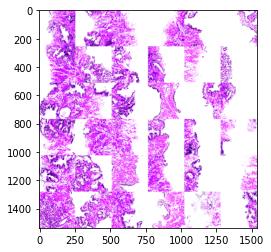

torch.Size([1, 1536, 1536, 3])
tensor([[1., 1., 1., 1., 0.]])
CPU times: user 1.83 s, sys: 234 ms, total: 2.06 s
Wall time: 1.03 s


In [28]:
%%time

# for image, label in train_loader:
#     print(image.shape)
#     image = image.permute(0,1,3,4,2)
#     print(image.shape)
#     plt.imshow(image[0][5])
#     plt.show()  
#     break

for image, label in train_loader:
    print(image.shape)
    image = image.permute(0,2,3,1)
    print(image.shape)
    plt.imshow(image[0])
    plt.show()  
    break
    
print(image.shape)
print(label)

In [30]:
del train_loader, train_dataset
gc.collect()

2594

# Model

In [31]:
class AdaptiveConcatPool2d(nn.Module):
    def __init__(self, sz=None):
      super().__init__()
      sz = sz or (1, 1)
      self.ap = nn.AdaptiveAvgPool2d(sz)
      self.mp = nn.AdaptiveMaxPool2d(sz)

    def forward(self, x): return torch.cat([self.mp(x), self.ap(x)], 1)
 
class Lambda(nn.Module):
    def __init__(self, f): super().__init__(); self.f = f

    def forward(self, x): return self.f(x)

class Mish(nn.Module):
    def __init__(self): super().__init__()

    def forward(self, x): return x*torch.tanh(F.softplus(x))

class Flatten(nn.Module):
    def __init__(self): super().__init__()

    def forward(self, x): return x.view(x.size(0), -1) 
    
class ProjectorBlock(nn.Module):
    def __init__(self, in_features, out_features):
        super(ProjectorBlock, self).__init__()
        self.op = nn.Conv2d(in_channels=in_features, out_channels=out_features, kernel_size=1, padding=0, bias=False)
    def forward(self, inputs):
        return self.op(inputs)

class LinearAttentionBlock(nn.Module):
    def __init__(self, in_features, normalize_attn=True):
        super(LinearAttentionBlock, self).__init__()
        self.normalize_attn = normalize_attn
        self.op = nn.Conv2d(in_channels=in_features, out_channels=1, kernel_size=1, padding=0, bias=False)
    def forward(self, l, g):
        N, C, W, H = l.size()
        c = self.op(l+g) # batch_sizex1xWxH
        if self.normalize_attn:
            a = F.softmax(c.view(N,1,-1), dim=2).view(N,1,W,H)
        else:
            a = torch.sigmoid(c)
        g = torch.mul(a.expand_as(l), l)
        if self.normalize_attn:
            g = g.view(N,C,-1).sum(dim=2) # batch_sizexC
        else:
            g = F.adaptive_avg_pool2d(g, (1,1)).view(N,C)
        #return c.view(N,1,W,H), g
        return g

'''
Grid attention block
Reference papers
Attention-Gated Networks https://arxiv.org/abs/1804.05338 & https://arxiv.org/abs/1808.08114
Reference code
https://github.com/ozan-oktay/Attention-Gated-Networks
'''
class GridAttentionBlock(nn.Module):
    def __init__(self, in_features_l, in_features_g, attn_features, up_factor, normalize_attn=False):
        super(GridAttentionBlock, self).__init__()
        self.up_factor = up_factor
        self.normalize_attn = normalize_attn
        self.W_l = nn.Conv2d(in_channels=in_features_l, out_channels=attn_features, kernel_size=1, padding=0, bias=False)
        self.W_g = nn.Conv2d(in_channels=in_features_g, out_channels=attn_features, kernel_size=1, padding=0, bias=False)
        self.phi = nn.Conv2d(in_channels=attn_features, out_channels=1, kernel_size=1, padding=0, bias=True)
    def forward(self, l, g):
        N, C, W, H = l.size()
        l_ = self.W_l(l)
        g_ = self.W_g(g)
        if self.up_factor > 1:
            g_ = F.interpolate(g_, scale_factor=self.up_factor, mode='bilinear', align_corners=False)
        c = self.phi(F.relu(l_ + g_)) # batch_sizex1xWxH
        # compute attn map
        if self.normalize_attn:
            a = F.softmax(c.view(N,1,-1), dim=2).view(N,1,W,H)
        else:
            a = torch.sigmoid(c)
        # re-weight the local feature
        f = torch.mul(a.expand_as(l), l) # batch_sizexCxWxH
        if self.normalize_attn:
            output = f.view(N,C,-1).sum(dim=2) # weighted sum
        else:
            output = F.adaptive_avg_pool2d(f, (1,1)).view(N,C)
        return c.view(N,1,W,H), output 

In [32]:
def conv3x3(in_planes, out_planes, stride=1, groups=1, dilation=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, groups=groups, bias=False, dilation=dilation)


def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(BasicBlock, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError('BasicBlock only supports groups=1 and base_width=64')
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out
    
class Bottleneck(nn.Module):
    # Bottleneck in torchvision places the stride for downsampling at 3x3 convolution(self.conv2)
    # while original implementation places the stride at the first 1x1 convolution(self.conv1)
    # according to "Deep residual learning for image recognition"https://arxiv.org/abs/1512.03385.
    # This variant is also known as ResNet V1.5 and improves accuracy according to
    # https://ngc.nvidia.com/catalog/model-scripts/nvidia:resnet_50_v1_5_for_pytorch.

    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(Bottleneck, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = int(planes * (base_width / 64.)) * groups
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

In [33]:
class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=1, zero_init_residual=False,
                 groups=1, width_per_group=64, replace_stride_with_dilation=None,
                 norm_layer=None, attention=True, normalize_attn=True):
        super(ResNet, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer
        self.attention = attention

        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError("replace_stride_with_dilation should be None "
                             "or a 3-element tuple, got {}".format(replace_stride_with_dilation))
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=1, stride=1, padding=3,
                               bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2,
                                       dilate=replace_stride_with_dilation[0])

        self.layer3 = self._make_layer(block, 256, layers[2], stride=2,
                                       dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2,
                                       dilate=replace_stride_with_dilation[2])
        
        self.avg_pool = nn.AdaptiveAvgPool3d((256, 1, 1))
        
        # Projectors & Compatibility functions
        if self.attention:
            #if block=='Bottleneck':
            self.projector1 = ProjectorBlock(512, 256)
            self.attn1 = LinearAttentionBlock(in_features=256, normalize_attn=normalize_attn)
            self.projector2 = ProjectorBlock(1024, 256)
            self.attn2 = LinearAttentionBlock(in_features=256, normalize_attn=normalize_attn)
            self.projector3 = ProjectorBlock(2048, 256)
            self.attn3 = LinearAttentionBlock(in_features=256, normalize_attn=normalize_attn)
            #else:
            #self.projector1 = ProjectorBlock(128, 512)
            #self.attn1 = LinearAttentionBlock(in_features=512, normalize_attn=normalize_attn)
            #self.projector2 = ProjectorBlock(256, 512)
            #self.attn2 = LinearAttentionBlock(in_features=512, normalize_attn=normalize_attn)
            #self.projector3 = ProjectorBlock(512, 512)
            #self.attn3 = LinearAttentionBlock(in_features=512, normalize_attn=normalize_attn)
        # final classification layer
        if self.attention:
            #if block=='Bottleneck':
            self.fc = nn.Linear(in_features=256*3, out_features=num_classes, bias=True)
            #else:
            #self.fc = nn.Linear(in_features=256*3, out_features=num_classes, bias=True)
        else:
            self.fc = nn.Linear(in_features=512, out_features=num_classes, bias=True)
        
        
        #self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        #self.fc = nn.Linear(512 * block.expansion, num_classes)
        #self.fc = nn.Linear(512 * 3, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1, dilate=False):
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, self.groups,
                            self.base_width, previous_dilation, norm_layer))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups=self.groups,
                                base_width=self.base_width, dilation=self.dilation,
                                norm_layer=norm_layer))

        return nn.Sequential(*layers)

    def _forward_impl(self, x):
        # See note [TorchScript super()]
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        l2 = self.layer2(x)
        l3 = self.layer3(l2)
        l4 = self.layer4(l3)
        x = self.avg_pool(l4)
        #x = torch.flatten(l4, 1)
        
        # pay attention
        if self.attention:
            g1 = self.attn1(self.projector1(l2), x)
            g2 = self.attn2(self.projector2(l3), x)
            g3 = self.attn3(self.projector3(l4), x)
            g = torch.cat((g1,g2,g3), dim=1) # batch_sizexC
            # classification layer
            x = self.fc(g) # batch_sizexnum_classes
        else:
            #c1, c2, c3 = None, None, None
            x = self.fc(x)
        #return [x, c1, c2, c3]

        #x = self.avgpool(x)
        #x = torch.flatten(x, 1)
        #x = self.fc(g)

        return x

    def forward(self, x):
        return self._forward_impl(x)
    
def _resnet(arch, block, layers, pretrained, progress, attention=True, normalize_attn=True, **kwargs):
    model = ResNet(block, layers, **kwargs)
    if pretrained:
        state_dict = load_state_dict_from_url(model_urls[arch],
                                              progress=progress)
        model.load_state_dict(state_dict)
    return model

def custom_resnet34(pretrained=False, progress=True, **kwargs):
    r"""ResNet-34 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet34', BasicBlock, [3, 4, 6, 3], pretrained, progress,
                   **kwargs)

def custom_resnet50(pretrained=False, progress=True, **kwargs):
    r"""ResNet-50 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet50', Bottleneck, [3, 4, 6, 3], pretrained, progress,
                   **kwargs)

def custom_resnext50_32x4d(pretrained=False, progress=True, **kwargs):
    r"""ResNeXt-50 32x4d model from
    `"Aggregated Residual Transformation for Deep Neural Networks" <https://arxiv.org/pdf/1611.05431.pdf>`_
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    kwargs['groups'] = 32
    kwargs['width_per_group'] = 4
    return _resnet('resnext50_32x4d', Bottleneck, [3, 4, 6, 3],
                   pretrained, progress, **kwargs)

def create_resnet9_model(pretrained=False, progress=True, **kwargs):
    r"""ResNet-34 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    kwargs['groups'] = 32
    kwargs['width_per_group'] = 4
    return _resnet('resnet34', BasicBlock, [1, 1, 1, 1], pretrained, progress,
                   **kwargs)

In [34]:
class Model(nn.Module):
    def __init__(self, arch='resnext50_32x4d', n=5, pre=True):
        super().__init__()
        #m = torch.hub.load('facebookresearch/semi-supervised-ImageNet1K-models', arch)
        #m = pretrainedmodels.__dict__['se_resnext50_32x4d'](pretrained=None)
        #m.load_state_dict(torch.load('se_resnext50_32x4d-a260b3a4.pth'))
        #m = torch.hub.load('pytorch/vision', 'resnet34', pretrained=True)
        #m = model = torch.hub.load('pytorch/vision:v0.6.0', 'resnext50_32x4d', pretrained=True)
        m = torch.hub.load('zhanghang1989/ResNeSt', 'resnest50', pretrained=True)
        #m = torch.hub.load('huawei-noah/ghostnet', 'ghostnet_1x', pretrained=True)
        #m = torch.hub.load('facebookresearch/semi-supervised-ImageNet1K-models', 'resnet50_ssl')
        self.enc = nn.Sequential(*list(m.children())[:-2])       
        nc = list(m.children())[-1].in_features
        self.head = nn.Sequential(AdaptiveConcatPool2d(),Flatten(),nn.Linear(2*nc,512),
                Mish(),nn.BatchNorm1d(512),nn.Dropout(0.3),nn.Linear(512,n))
        
    def forward(self, x):
        shape = x.shape
        n = shape[1]
        x = x.view(-1,shape[2],shape[3],shape[4])
        x = self.enc(x)
        shape = x.shape
        x = x.view(-1,n,shape[1],shape[2],shape[3]).permute(0,2,1,3,4).contiguous()\
          .view(-1,shape[1],shape[2]*n,shape[3])
        x = self.head(x)
        return x

In [35]:
class CustomModel(nn.Module):
    def __init__(self, arch='resnext50_32x4d_ssl', n=5, pre=True):
        super().__init__()
        #m = models.resnext50_32x4d(pretrained=True)
        m = pretrainedmodels.__dict__['se_resnet50'](pretrained=None)
        m.load_state_dict(torch.load('se_resnet50-ce0d4300.pth'))
        self.enc = nn.Sequential(*list(m.children())[:-2]) 
        nc = list(m.children())[-1].in_features
        self.head = nn.Sequential(nn.AdaptiveAvgPool2d(1),Flatten(),Mish(),
                             nn.Dropout(0.3),nn.Linear(nc,n))
    def forward(self, x):
      x = self.enc(x)
      #x: bs*N x C x 4 x 4
      x = self.head(x)
      return x

In [36]:
class CustomSeResnet50(nn.Module):
    def __init__(self, n=5, pre=True):
        super().__init__()
        m = ptcv_get_model("seresnet50", pretrained=True)
        self.enc = nn.Sequential(*list(m.children())[-2]) 
        nc = list(m.children())[-1].in_features
        self.concat = AdaptiveConcatPool2d()
        self.head = nn.Sequential(
                    Flatten(),
                    nn.BatchNorm1d(4096, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                    #nn.Dropout(p=0.3),
                    nn.Linear(4096, 768, bias=True),
                    nn.ReLU(inplace=True),
                    nn.BatchNorm1d(768, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                    #nn.Dropout(p=0.3),
                    nn.Linear(768, 256, bias=True),
                    nn.ReLU(inplace=True),
                    nn.BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                    nn.Dropout(p=0.3),
                    nn.Linear(256, n))
        
    def forward(self, x):
        x = self.enc(x)
        x = self.concat(x)
        x = self.head(x)
        return x

In [37]:
# from torchsummary import summary
# model = CustomSeResnet50().to(device)
# #print(model)
# summary(model, (3, 256, 256))
# del model
# torch.cuda.empty_cache()

In [38]:
class CustomSEResNeXt(nn.Module):
    def __init__(self, arch='resnext50_32x4d_ssl',in_channels=3, out_channels=5):
        super().__init__()
        #self.model = torch.hub.load('facebookresearch/semi-supervised-ImageNet1K-models', arch)
        #self.model = pretrainedmodels.__dict__['se_resnext50_32x4d'](pretrained=None)
        #self.model.load_state_dict(torch.load('se_resnext50_32x4d-a260b3a4.pth'))
        self.model = torch.hub.load('zhanghang1989/ResNeSt', 'resnest50', pretrained=True)
        #self.model = torch.hub.load('pytorch/vision', 'resnet34', pretrained=True)
        #self.model.avg_pool = nn.AdaptiveAvgPool2d(1)
        #self.model.last_linear = nn.Linear(self.model.last_linear.in_features, out_channels)
        self.model.fc = nn.Linear(self.model.fc.in_features, out_channels)
        
    def forward(self, x):
      x = self.model(x)
      return x

In [39]:
class CustomResnet34(nn.Module):
    def __init__(self, n=5, pre=True):
        super().__init__()
        self.model = torch.hub.load('pytorch/vision', 'resnet34', pretrained=True)
        self.modelfc = torch.nn.Identity()
        self.head = nn.Sequential(
                    Flatten(),
                    #nn.BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                    #nn.Dropout(p=0.3),
                    nn.Linear(1000, 256, bias=True),
                    nn.ReLU(inplace=True),
                    #nn.BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                    #nn.Dropout(p=0.3),
                    nn.Linear(256, 128, bias=True),
                    nn.ReLU(inplace=True),
                    #nn.BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                    nn.Dropout(p=0.3),
                    nn.Linear(128, n))
        
    def forward(self, x):
        x = self.model(x)
        x = self.head(x)
        return x

In [40]:
# class CustomEfficientNet(nn.Module):
#     def __init__(self, n=5):
#         super().__init__()
#         self.model = EfficientNet.from_pretrained("efficientnet-b0", advprop=False)
#         #self.model.avg_pool = nn.AdaptiveAvgPool2d(1)
#         #self.model._fc = nn.Linear(self.model._fc.in_features, 1000)
#         self.model._fc = torch.nn.Identity()
#         self.head = nn.Sequential(
#                     Flatten(),
#                     nn.BatchNorm1d(1280, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
#                     #nn.Dropout(p=0.3),
#                     nn.Linear(1280, 768, bias=True),
#                     nn.ReLU(inplace=True),
#                     nn.BatchNorm1d(768, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
#                     #nn.Dropout(p=0.3),
#                     nn.Linear(768, 256, bias=True),
#                     nn.ReLU(inplace=True),
#                     nn.BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
#                     nn.Dropout(p=0.1),
#                     nn.Linear(256, n))
        
#     def forward(self, x):
#         x = self.model(x)
#         x = self.head(x)
#         return x

In [41]:
# class CustomEfficientNet(nn.Module):
#     def __init__(self, n=5):
#         super().__init__()
#         self.model = EfficientNet.from_pretrained("efficientnet-b0", advprop=False)
#         #self.model.avg_pool = nn.AdaptiveAvgPool2d(1)
#         #self.model._fc = nn.Linear(self.model._fc.in_features, 1000)
#         self.model._fc = torch.nn.Identity()
#         self.head = nn.Sequential(
#                     Flatten(),
#                     nn.BatchNorm1d(1280, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
#                     nn.Linear(1280, 256, bias=True),
#                     nn.ReLU(inplace=True),
#                     nn.BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
#                     nn.Dropout(p=0.1),
#                     nn.Linear(256, n))
        
#     def forward(self, x):
#         x = self.model(x)
#         x = self.head(x)
#         return x

In [42]:
class CustomEfficientNet(nn.Module):
    def __init__(self,in_channels=3, out_channels=5):
        super().__init__()
        self.model = EfficientNet.from_pretrained("efficientnet-b0", advprop=False)
        #self.model.set_swish(memory_efficient=False)
        #self.model.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.model._fc = nn.Linear(self.model._fc.in_features, out_channels)
        
    def forward(self, x):
      x = self.model(x)
      return x

In [43]:
# class CustomEfficientNet(nn.Module):
#     def __init__(self, arch='resnext50_32x4d_ssl', out_channels=5, pre=True):
#         super().__init__()
#         self.m = EfficientNet.from_pretrained("efficientnet-b0", advprop=False)
#         self.m._fc = nn.Linear(self.m._fc.in_features, out_channels)
        
#     def forward(self, x):
#         shape = x.shape #x: bs x N x 3 x img_sz x img_sz
#         n = shape[1]
#         x = x.view(-1,shape[2],shape[3],shape[4]) #x: bs*N x 3 x img_sz x img_sz
#         x = self.m(x)
#         shape = x.shape
#         print(shape)
# #         x = x.view(-1,n,shape[1],shape[2],shape[3]).permute(0,2,1,3,4).contiguous()\
# #           .view(-1,shape[1],shape[2]*n,shape[3])
# #         x = self.head(x)
#         #x = torch.cat(x)
#         return x

In [44]:
class InceptionV3(nn.Module):
    def __init__(self,in_channels=3, out_channels=5):
        super().__init__()
        self.model = ptcv_get_model("inceptionV3", pretrained=True)
        #self.model = EfficientNet.from_pretrained("efficientnet-b0", advprop=False)
        #self.model.set_swish(memory_efficient=False)
        self.model.features.final_pool = nn.AdaptiveAvgPool2d(1)
        self.model.output.fc = nn.Linear(self.model.output.fc.in_features, out_channels)
        
    def forward(self, x):
      x = self.model(x)
      return x

In [45]:
class mixnet_m(nn.Module):
    def __init__(self,in_channels=3, out_channels=5):
        super().__init__()
        #self.model = ptcv_get_model("cbam_resnet50", pretrained=True)
        self.model = ptcv_get_model("mixnet_s", pretrained=True)
        #self.model.set_swish(memory_efficient=False)
        self.model.features.final_pool = nn.AdaptiveAvgPool2d(1)
        self.model.output = nn.Linear(self.model.output.in_features, out_channels)
        
    def forward(self, x):
      x = self.model(x)
      return x

In [49]:
class WrappedModel(nn.Module):
    def __init__(self, module):
        super(WrappedModel, self).__init__()
        self.module = module
    def forward(self, x):
        return self.module(x)

# Train

In [50]:
from sklearn.metrics import cohen_kappa_score

def quadratic_weighted_kappa(y_hat, y):
    return cohen_kappa_score(y_hat, y, weights='quadratic')


In [51]:
# train_data, valid_data= train_test_split(train_csv, test_size=0.2, shuffle=True, 
#                                          random_state=42, stratify=train_csv['isup_grade'])

# _, valid_k= train_test_split(train_csv, test_size=0.2, shuffle=True, 
#                                          random_state=777, stratify=train_csv['isup_grade'])


# valid_k = pd.DataFrame(valid_k)
# valid_k = valid_k.loc[valid_k['data_provider'] == 'karolinska']

train_idx = np.where((train_csv['fold'] != fold))[0]
valid_idx = np.where((train_csv['fold'] == fold))[0]

train_data  = train_csv.loc[train_idx]
valid_data = train_csv.loc[valid_idx] 

valid_k = valid_data.loc[valid_data['data_provider'] == 'karolinska']

train_dataset = PANDADataset(train_data , CFG.image_size, CFG.N, transform1=transforms_train1, transform2=transforms_train2)
valid_dataset = PANDADataset(valid_data, CFG.image_size, CFG.N, transform1=transforms_val, transform2=transforms_val)
valid_kaggle = PANDADataset(valid_k, CFG.image_size, CFG.N, transform1=transforms_val, transform2=transforms_val)

train_loader = DataLoader(train_dataset, batch_size=CFG.batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=CFG.batch_size, shuffle=False,  num_workers=num_workers, pin_memory=True)
valid_kaggle_loader = DataLoader(valid_kaggle, batch_size=CFG.batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)

if resume:
    model = CustomEfficientNet()
    model = WrappedModel(model)
    model.load_state_dict(torch.load('model/model_030.pt'))
    #checkpoint = torch.load('checkpoint.pt')
    #model.load_state_dict(checkpoint['state_dict'])
    model.to(device)
    
    #CFG.lr = checkpoint['lr']
    
    optimizer = Adam(model.parameters(), lr=CFG.lr, amsgrad=False)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, CFG.epochs)
    #scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=2, verbose=True, eps=1e-6) 
    #scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=CFG.lr, pct_start=0.0, cycle_momentum=True, 
    #                                        steps_per_epoch=len(train_loader),epochs=CFG.epochs, div_factor=125.0)
    
    
    if fp16:
        opt_level = 'O1'
        model, optimizer = amp.initialize(model, optimizer, opt_level=opt_level)
        #amp.load_state_dict(checkpoint['amp'])
    
    #optimizer.load_state_dict(checkpoint['optimizer'])
    #scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    #epoch = checkpoint['epoch']
    #CFG.epochs = CFG.epochs - epoch
    print("resuming...")
    print("total epochs:", CFG.epochs)
else:
    model = CustomEfficientNet()
    model.to(device)
    optimizer = Adam(model.parameters(), lr=CFG.lr, amsgrad=False)
    #optimizer = SGD(model.parameters(), lr=CFG.lr, momentum=0.9)
    #scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, CFG.epochs)
    #optimizer = Adam(model.parameters(), lr=CFG.lr/CFG.warmup_factor, amsgrad=False)
    #scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=2, verbose=True, eps=1e-6)
    if accumulate:
        print("Accumulating gradients")
#         scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=CFG.lr, pct_start=0.45, cycle_momentum=True, 
#                                                 steps_per_epoch=int(len(train_loader)/accumulation_steps),epochs=CFG.epochs, div_factor=20.0, final_div_factor=1000.0)

        scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=CFG.lr, pct_start=0.0, cycle_momentum=True, 
                                                steps_per_epoch=int(len(train_loader)/accumulation_steps),epochs=CFG.epochs, div_factor=125.0)
    
    else:
        print("Not accumulating gradients")
        scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=CFG.lr, pct_start=0.45, cycle_momentum=True, 
                                                steps_per_epoch=len(train_loader),epochs=CFG.epochs, div_factor=25.0, final_div_factor=1000.0)
    
        #scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, CFG.epochs)
    
    if fp16:
        opt_level = 'O1'
        model, optimizer = amp.initialize(model, optimizer, opt_level=opt_level)

print(device)    
    
if torch.cuda.device_count() > 1:
  print("Let's use", torch.cuda.device_count(), "GPUs!")
  model = nn.DataParallel(model)

#criterion = nn.CrossEntropyLoss()
criterion = nn.BCEWithLogitsLoss()

Loaded pretrained weights for efficientnet-b0
Accumulating gradients
Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
cuda
Let's use 2 GPUs!


In [53]:
def train(epoch):
    model.train()
    train_loss = []
    PREDS=[]
    TARGETS=[]
    optimizer.zero_grad()
    
    bar = tqdm(enumerate(train_loader), total=len(train_loader))
    for steps, (data, target) in bar:
        
        data, target = data.to(device), target.to(device)
        #optimizer.zero_grad()
        
        logits = model(data)
        loss = criterion(logits, target)
        loss = loss / accumulation_steps
        
        pred = logits.sigmoid().sum(1).detach().round()
        PREDS.append(pred)
        
        TARGETS.append(target.sum(1))
        
        if fp16:
            with amp.scale_loss(loss, optimizer) as scaled_loss:
                scaled_loss.backward()
        else:
            loss.backward()
            
        if steps % accumulation_steps == 0:
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()
        
#         optimizer.step()
#         scheduler.step()

        loss_np = loss.detach().cpu().numpy()
        train_loss.append(loss_np)
        smooth_loss = sum(train_loss[-100:]) / min(len(train_loss), 100)
        bar.set_description('loss: %.5f, smth: %.5f' % (loss_np, smooth_loss))
        neptune.send_metric('lr_iter', optimizer.param_groups[0]['lr'])
        
    PREDS = torch.cat(PREDS).cpu().numpy()
    TARGETS = torch.cat(TARGETS).cpu().numpy()   
    score = quadratic_weighted_kappa(PREDS, TARGETS)
    
    train_loss = np.mean(train_loss)
    
    neptune.send_metric('train_loss', train_loss)
    neptune.send_metric('train_qwk', score)
    neptune.send_metric('lr', optimizer.param_groups[0]['lr'])
    return train_loss, score

In [54]:
def valid(epoch):
    model.eval()
    val_loss = []
    LOGITS = []
    PREDS = []
    TARGETS = []

    with torch.no_grad():
        for (data, target) in tqdm(valid_loader):
            data, target = data.to(device), target.to(device)
            logits = model(data)

            loss = criterion(logits, target)

            pred = logits.sigmoid().sum(1).detach().round()
            LOGITS.append(logits)
            PREDS.append(pred)
            TARGETS.append(target.sum(1))

            val_loss.append(loss.detach().cpu().numpy())
        val_loss = np.mean(val_loss)

    LOGITS = torch.cat(LOGITS).cpu().numpy()
    PREDS = torch.cat(PREDS).cpu().numpy()
    TARGETS = torch.cat(TARGETS).cpu().numpy()
    
    acc = (PREDS == TARGETS).mean() * 100.
    score = quadratic_weighted_kappa(PREDS, TARGETS)
    
    neptune.send_metric('valid_loss', val_loss)
    neptune.send_metric('valid_qwk', score)
    neptune.send_metric('valid_acc', acc)
    return TARGETS, score, val_loss, PREDS

In [57]:
def valid_kaggle(epoch):
    model.eval()
    val_loss = []
    LOGITS = []
    PREDS = []
    TARGETS = []

    with torch.no_grad():
        for (data, target) in tqdm(valid_kaggle_loader):
            data, target = data.to(device), target.to(device)
            logits = model(data)

            loss = criterion(logits, target)

            pred = logits.sigmoid().sum(1).detach().round()
            LOGITS.append(logits)
            PREDS.append(pred)
            TARGETS.append(target.sum(1))

            val_loss.append(loss.detach().cpu().numpy())
        val_loss = np.mean(val_loss)

    LOGITS = torch.cat(LOGITS).cpu().numpy()
    PREDS = torch.cat(PREDS).cpu().numpy()
    TARGETS = torch.cat(TARGETS).cpu().numpy()
    acc = (PREDS == TARGETS).mean() * 100.
    score = quadratic_weighted_kappa(PREDS, TARGETS)
    
    neptune.send_metric('karolinska_score', score)
    return score

In [58]:
def run_main(epochs):
    coeff = []
    best_score = -100
    best_loss = np.inf
    best_preds = None
    idx_stop = 0
    for epoch in range(1, epochs+1):
        start_time = time.time()
        torch.cuda.empty_cache()
        gc.collect()
        #scheduler.step(epoch)
        #scheduler.step(epoch-1)
        print('lr:', optimizer.param_groups[0]["lr"])
        avg_train_loss, train_score = train(epoch) 
        valid_labels, valid_score, avg_val_loss, best_preds = valid(epoch)
        valid_score_k = valid_kaggle(epoch)
        
        elapsed = time.time() - start_time
        LOGGER.debug(f'  Epoch {epoch} - avg_train_loss: {avg_train_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
        LOGGER.debug(f'  Epoch {epoch} - train_QWK: {train_score}  valid_QWK: {valid_score}  karolinska_QWK: {valid_score_k}')
        torch.save(model.state_dict(), 'model/model_{epoch:03}.pt'.format(epoch=epoch))  
        checkpoint = {
            'epoch': epoch,
            'lr': optimizer.param_groups[0]['lr'],
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'amp': amp.state_dict()
            }
        torch.save(checkpoint, 'checkpoint.pt')
    return best_preds, valid_labels        

In [ ]:
preds = []
valid_labels = []
#for fold in range(CFG.n_fold):
_preds, _valid_labels = run_main(CFG.epochs)
preds.append(_preds)
valid_labels.append(_valid_labels)

lr: 0.0007999997167815846


loss: 0.03937, smth: 0.05054:   4%|▎         | 39/1062 [00:42<13:34,  1.26it/s] 

In [ ]:
# CV
preds = np.concatenate(preds)
valid_labels = np.concatenate(valid_labels)

score = quadratic_weighted_kappa(preds, valid_labels)
LOGGER.debug(f'CV QWK: {score}')

In [ ]:
neptune.stop()